# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [19]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.378676
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [20]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.372334 analytic: -1.372334, relative error: 3.848943e-08
numerical: 0.904032 analytic: 0.904032, relative error: 2.129730e-08
numerical: 0.426976 analytic: 0.426976, relative error: 4.056916e-08
numerical: 1.408007 analytic: 1.408007, relative error: 3.118424e-08
numerical: 0.516204 analytic: 0.516204, relative error: 4.593056e-08
numerical: -0.593501 analytic: -0.593502, relative error: 3.546929e-08
numerical: -1.120498 analytic: -1.120498, relative error: 3.203523e-09
numerical: -0.659762 analytic: -0.659762, relative error: 2.150643e-08
numerical: -4.198776 analytic: -4.198776, relative error: 1.303274e-08
numerical: -1.435355 analytic: -1.435355, relative error: 4.688649e-08
numerical: -1.564959 analytic: -1.564959, relative error: 1.706623e-08
numerical: 2.227693 analytic: 2.227693, relative error: 3.691690e-08
numerical: -0.545691 analytic: -0.545691, relative error: 3.673879e-08
numerical: -0.002106 analytic: -0.002106, relative error: 3.685319e-06
numerical: -0.34

In [22]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.378676e+00 computed in 0.105717s
vectorized loss: 2.378676e+00 computed in 0.001963s
Loss difference: 0.000000
Gradient difference: 0.000000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
learning_rate = [i * 1e-7 for i in range(1, 100, 4)]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for ls in learning_rate:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate = ls, reg = rs, num_iters = 1500,verbose = True)
        y_train_pred = softmax.predict(X_train)
        accu_train = np.mean(y_train_pred == y_train)
        y_val_pred = softmax.predict(X_val)
        accu_val = np.mean(y_val_pred == y_val)
        results[(ls,rs)] = [accu_train, accu_val]
        if accu_val > best_val:
            best_val = accu_val
            best_softmax = softmax
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 773.887424
iteration 100 / 1500: loss 284.232568
iteration 200 / 1500: loss 105.327820
iteration 300 / 1500: loss 39.804563
iteration 400 / 1500: loss 15.888788
iteration 500 / 1500: loss 7.132969
iteration 600 / 1500: loss 3.941938
iteration 700 / 1500: loss 2.811446
iteration 800 / 1500: loss 2.342113
iteration 900 / 1500: loss 2.130057
iteration 1000 / 1500: loss 2.127157
iteration 1100 / 1500: loss 2.091804
iteration 1200 / 1500: loss 2.067490
iteration 1300 / 1500: loss 2.026890
iteration 1400 / 1500: loss 2.067093
iteration 0 / 1500: loss 1563.622803
iteration 100 / 1500: loss 210.624209
iteration 200 / 1500: loss 30.039139
iteration 300 / 1500: loss 5.873536
iteration 400 / 1500: loss 2.621759
iteration 500 / 1500: loss 2.231255
iteration 600 / 1500: loss 2.184452
iteration 700 / 1500: loss 2.175142
iteration 800 / 1500: loss 2.143386
iteration 900 / 1500: loss 2.116088
iteration 1000 / 1500: loss 2.169799
iteration 1100 / 1500: loss 2.096732
iteration 1

iteration 100 / 1500: loss 2.258104
iteration 200 / 1500: loss 2.235928
iteration 300 / 1500: loss 2.216015
iteration 400 / 1500: loss 2.218021
iteration 500 / 1500: loss 2.216128
iteration 600 / 1500: loss 2.203913
iteration 700 / 1500: loss 2.195359
iteration 800 / 1500: loss 2.223137
iteration 900 / 1500: loss 2.202602
iteration 1000 / 1500: loss 2.218403
iteration 1100 / 1500: loss 2.241150
iteration 1200 / 1500: loss 2.211702
iteration 1300 / 1500: loss 2.172810
iteration 1400 / 1500: loss 2.150569
iteration 0 / 1500: loss 761.039392
iteration 100 / 1500: loss 2.125433
iteration 200 / 1500: loss 2.200962
iteration 300 / 1500: loss 2.155036
iteration 400 / 1500: loss 2.128371
iteration 500 / 1500: loss 2.125478
iteration 600 / 1500: loss 2.084886
iteration 700 / 1500: loss 2.153150
iteration 800 / 1500: loss 2.138556
iteration 900 / 1500: loss 2.190443
iteration 1000 / 1500: loss 2.203520
iteration 1100 / 1500: loss 2.170243
iteration 1200 / 1500: loss 2.111121
iteration 1300 / 150

iteration 200 / 1500: loss 3.272464
iteration 300 / 1500: loss 2.736291
iteration 400 / 1500: loss 3.807776
iteration 500 / 1500: loss 4.924820
iteration 600 / 1500: loss 2.945531
iteration 700 / 1500: loss 3.628338
iteration 800 / 1500: loss 2.749809
iteration 900 / 1500: loss 2.958591
iteration 1000 / 1500: loss 3.167532
iteration 1100 / 1500: loss 3.258147
iteration 1200 / 1500: loss 3.455854
iteration 1300 / 1500: loss 3.066103
iteration 1400 / 1500: loss 3.263344
iteration 0 / 1500: loss 1564.445794
iteration 100 / 1500: loss 5.122977
iteration 200 / 1500: loss 6.369879
iteration 300 / 1500: loss 6.122887
iteration 400 / 1500: loss 5.416167
iteration 500 / 1500: loss 4.427662
iteration 600 / 1500: loss 6.183740
iteration 700 / 1500: loss 7.327406
iteration 800 / 1500: loss 5.452758
iteration 900 / 1500: loss 4.908510
iteration 1000 / 1500: loss 5.740634
iteration 1100 / 1500: loss 5.433063
iteration 1200 / 1500: loss 6.657967
iteration 1300 / 1500: loss 5.565836
iteration 1400 / 1

iteration 200 / 1500: loss 12.493882
iteration 300 / 1500: loss 11.166934
iteration 400 / 1500: loss 10.885315
iteration 500 / 1500: loss 12.505615
iteration 600 / 1500: loss 10.737546
iteration 700 / 1500: loss 12.722705
iteration 800 / 1500: loss 13.041186
iteration 900 / 1500: loss 12.343258
iteration 1000 / 1500: loss 12.447243
iteration 1100 / 1500: loss 12.585495
iteration 1200 / 1500: loss 12.502766
iteration 1300 / 1500: loss 11.409977
iteration 1400 / 1500: loss 11.378075
iteration 0 / 1500: loss 774.265684
iteration 100 / 1500: loss 5.850169
iteration 200 / 1500: loss 4.831183
iteration 300 / 1500: loss 7.572967
iteration 400 / 1500: loss 6.346964
iteration 500 / 1500: loss 6.074633
iteration 600 / 1500: loss 6.828940
iteration 700 / 1500: loss 7.848380
iteration 800 / 1500: loss 5.212709
iteration 900 / 1500: loss 5.721803
iteration 1000 / 1500: loss 6.419801
iteration 1100 / 1500: loss 7.794178
iteration 1200 / 1500: loss 5.087548
iteration 1300 / 1500: loss 6.599682
iterat

In [26]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.343000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



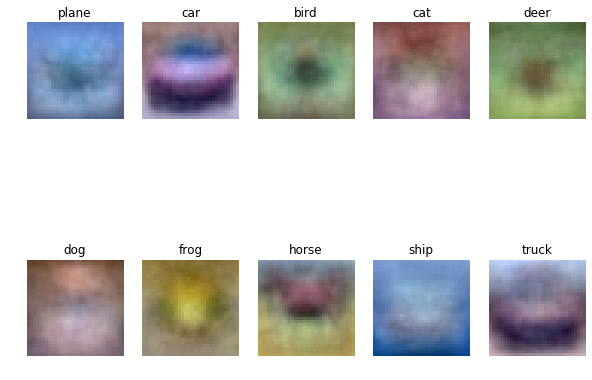

In [27]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])